In [1]:
# Imports
%matplotlib inline
from datetime import timedelta
from scipy.stats import bernoulli
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
import gzip
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import time

In [2]:
# Dimensions of the data

# We know that images are 48 pixels in each dimension
in_height = 48
in_width = 48

# Images are stored in one-dimensional arrays of this length
image_size_flat = in_height * in_width

# Tuple with height and width of images used to reshape arrays
image_shape = (in_height, in_width)

# Classes info
classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Number of classes
num_classes = len(classes)

# Number of colour channels for the images: 1 channel for gray-scale
# Channels mean number of primary colors
num_channels = 1

In [3]:
# Placeholder variables

# Placeholder variable for the input images
x = tf.placeholder(tf.float32, shape=[None, image_size_flat])

# Reshape 'x'
x_image = tf.reshape(x, shape=[-1, in_height, in_width, num_channels])

# Placeholder variable for the true labels associated with the images
y_true = tf.placeholder(tf.float32, shape=[None, num_classes])

# We could also have a placeholder variable for the class-number,
# but we will instead calculate it using argmax
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


In [4]:
# Load Dataset
def load_dataset(filename):
    upload_file = gzip.open(filename, 'rb')
    images_set, labels_set = joblib.load(upload_file)
    upload_file.close()

    return images_set, labels_set

In [5]:
# Returns the values of the function for images_set, labels_set on train-set
data_train_images, data_train_labels = load_dataset('Datasets/FER-2013/FER-2013-with-DA-training-set.pkl.gz')

In [6]:
# Returns the values of the function for images_set, labels_set on test-set
data_test_images, data_test_labels = load_dataset('Datasets/FER-2013/FER-2013-test-set.pkl.gz')

In [7]:
# Class labels are One-Hot coded, meaning that each label is a vector with 10 elements,
# all of which are zero except one element
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    
    return labels_one_hot

In [8]:
# Call function dense_to_one_hot()
data_train_labels  = dense_to_one_hot(labels_dense=data_train_labels, num_classes=num_classes)
data_test_labels  = dense_to_one_hot(labels_dense=data_test_labels, num_classes=num_classes)

In [9]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data_train_images)))
print("- Test-set:\t\t{}".format(len(data_test_images)))

Size of:
- Training-set:		91510
- Test-set:		3589


In [10]:
data_test_cls = np.argmax(data_test_labels, axis=1)
# print data_test_cls

In [11]:
# Helper-function for catch the class
# number and print its corresponding name
def get_emotion(num_class):
    if num_class == 0:
        return 'Angry'
    elif num_class == 1:
        return 'Disgust'
    elif num_class == 2:
        return 'Fear'
    elif num_class == 3:
        return 'Happy'
    elif num_class == 4:
        return 'Sad'
    elif num_class == 5:
        return 'Surprise'
    elif num_class == 6:
        return 'Neutral'

In [12]:
# Helper-function for plotting images
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image
        ax.imshow(images[i].reshape(image_shape), cmap='gray')

        # Show true and predicted classes
        # T = True, and P = Predicted
        if cls_pred is None:
            xlabel = "T: {0}".format(get_emotion(cls_true[i]))
        else:
            xlabel = "T: {0}, P: {1}".format(get_emotion(cls_true[i]), get_emotion(cls_pred[i]))

        # Show the classes as the label on the x-axis
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

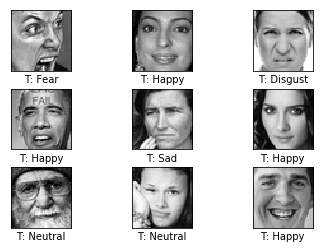

In [13]:
# Plot a few images to see if data is correct

# Get the first images from the test-set
images = data_test_images[0:9]

# Get the true classes for those images
cls_true = data_test_cls[0:9]

# Plot the images and labels using our helper-function above
plot_images(images=images, cls_true=cls_true)

In [14]:
# Convolutional Layer 1

# Convolution filters are 3 x 3 pixels
filter_height_1 = 3
filter_width_1 = 3

# There are 8 of these filters
num_filters_1 = 8

# Convolutional Layer 2

# Convolution filters are 3 x 3 pixels
filter_height_2 = 3 
filter_width_2 = 3

# There are 16 of these filters
num_filters_2 = 16

# Convolutional Layer 3

# Convolution filters are 3 x 3 pixels
filter_height_3 = 3
filter_width_3 = 3

# There are 32 of these filters
num_filters_3 = 32

# Convolutional Layer 4

# Convolution filters are 3 x 3 pixels
filter_height_4 = 3
filter_width_4 = 3

# There are 64 of these filters
num_filters_4 = 64

# Convolutional Layer 5

# Convolution filters are 3 x 3 pixels
filter_height_5 = 3
filter_width_5 = 3

# There are 128 of these filters
num_filters_5 = 128

# Fully-connected layer
# Number of neurons in fully-connected layer
fc_size = 128

In [15]:
# Non-trainable filters initialized with distribution
# of Bernoulli as in article and then it's non-trainable
def new_weights_non_trainable(h,
                              w,
                              num_input,
                              num_output,
                              sparsity=0.5):
    
    # Number of elements
    num_elements = h * w * num_input * num_output
    
    # Create an array with n number of elements
    array = np.arange(num_elements)
    
    # Random shuffle it
    np.random.shuffle(array)
    
    # Fill with 0
    weight = np.zeros([num_elements])
    
    # Get number of elements in array that need be non-zero
    ind = int(sparsity * num_elements + 0.5)
    
    # Get it piece as indexes for weight matrix
    index = array[:ind]
  
    for i in index:
        # Fill those indexes with bernoulli distribution
        # Method rvs = random variates
        weight[i] = bernoulli.rvs(0.5)*2-1

    # Reshape weights array for matrix that we need
    weights = weight.reshape(h, w, num_input, num_output)
    
    # print weights

    return weights

In [16]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [17]:
def new_biases(length):
    # Equivalent to y intercept
    # Constant value carried over across matrix math
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [18]:
# Think of it as one block

def new_LBC_layer(input,              # The previous layer
                  filter_height,      # Height of each filter
                  filter_width,       # Width of each filter
                  in_channels,        # Num. channels in prev. layer
                  out_channels,       # # Number of filters
                  use_pooling=True):  # Use 2x2 max-pooling
    
    # The out_channels of the previous layer are the in_channels of the next layer

    # Shape of the filter-weights for the convolution
    # This format is determined by the TensorFlow API
    # shape = [filter_height, filter_width, in_channels, out_channels]

    # Non-trainable filters
    anchor_weights = tf.Variable(new_weights_non_trainable(h=filter_height,
                                                           w=filter_width,
                                                           num_input=in_channels,
                                                           num_output=out_channels).astype(np.float32),
                                                           trainable=False)
    
    # Difference Maps
    difference_maps = tf.nn.conv2d(input=input,
                                   filter=anchor_weights,
                                   strides=[1, 1, 1, 1],
                                   padding='SAME')
    
    # Non-linear unit is ReLU, as in article
    
    # Bit Maps
    bit_maps = tf.nn.relu(difference_maps)
    
    # Set of learnable linear weights is a convolution with 1x1 kernels,
    # without bias and without non-linear unit

    shape = [1, 1, out_channels, 1]
    
    weights = new_weights(shape)

    # Feature Maps
    feature_maps = tf.nn.conv2d(input=bit_maps, 
                                filter=weights,
                                strides=[1, 1, 1, 1],
                                padding='SAME')

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window
        feature_maps = tf.nn.max_pool(value=feature_maps,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # We will plot them later
    return feature_maps, anchor_weights, weights

In [19]:
# Convolutional layer 1 
feature_maps_conv_1, anchor_weights_conv_1, weights_conv_1 = new_LBC_layer(input=x_image,
                                                                           filter_height=filter_height_1,
                                                                           filter_width=filter_width_1,
                                                                           in_channels=num_channels,
                                                                           out_channels=num_filters_1,
                                                                           use_pooling=False)

In [20]:
feature_maps_conv_1

<tf.Tensor 'Conv2D_1:0' shape=(?, 48, 48, 1) dtype=float32>

In [21]:
anchor_weights_conv_1

<tf.Variable 'Variable:0' shape=(3, 3, 1, 8) dtype=float32_ref>

In [22]:
weights_conv_1

<tf.Variable 'Variable_1:0' shape=(1, 1, 8, 1) dtype=float32_ref>

In [23]:
# Convolutional layer 2
feature_maps_conv_2, anchor_weights_conv_2, weights_conv_2 = new_LBC_layer(input=feature_maps_conv_1,
                                                                           filter_height=filter_height_2,
                                                                           filter_width=filter_width_2,
                                                                           in_channels=1,
                                                                           out_channels=num_filters_2,
                                                                           use_pooling=False)

In [24]:
feature_maps_conv_2

<tf.Tensor 'Conv2D_3:0' shape=(?, 48, 48, 1) dtype=float32>

In [25]:
anchor_weights_conv_2

<tf.Variable 'Variable_2:0' shape=(3, 3, 1, 16) dtype=float32_ref>

In [26]:
weights_conv_2

<tf.Variable 'Variable_3:0' shape=(1, 1, 16, 1) dtype=float32_ref>

In [27]:
# Convolutional layer 3
feature_maps_conv_3, anchor_weights_conv_3, weights_conv_3 = new_LBC_layer(input=feature_maps_conv_2,
                                                                           filter_height=filter_height_3,
                                                                           filter_width=filter_width_3,
                                                                           in_channels=1,
                                                                           out_channels=num_filters_3,
                                                                           use_pooling=False)

In [28]:
feature_maps_conv_3

<tf.Tensor 'Conv2D_5:0' shape=(?, 48, 48, 1) dtype=float32>

In [29]:
anchor_weights_conv_3

<tf.Variable 'Variable_4:0' shape=(3, 3, 1, 32) dtype=float32_ref>

In [30]:
weights_conv_3

<tf.Variable 'Variable_5:0' shape=(1, 1, 32, 1) dtype=float32_ref>

In [31]:
# Convolutional layer 4
feature_maps_conv_4, anchor_weights_conv_4, weights_conv_4 = new_LBC_layer(input=feature_maps_conv_3,
                                                                           filter_height=filter_height_4,
                                                                           filter_width=filter_width_4,
                                                                           in_channels=1,
                                                                           out_channels=num_filters_4,
                                                                           use_pooling=False)

In [32]:
feature_maps_conv_4

<tf.Tensor 'Conv2D_7:0' shape=(?, 48, 48, 1) dtype=float32>

In [33]:
anchor_weights_conv_4

<tf.Variable 'Variable_6:0' shape=(3, 3, 1, 64) dtype=float32_ref>

In [34]:
weights_conv_4

<tf.Variable 'Variable_7:0' shape=(1, 1, 64, 1) dtype=float32_ref>

In [35]:
# Convolutional layer 5
feature_maps_conv_5, anchor_weights_conv_5, weights_conv_5 = new_LBC_layer(input=feature_maps_conv_4,
                                                                           filter_height=filter_height_5,
                                                                           filter_width=filter_width_5,
                                                                           in_channels=1,
                                                                           out_channels=num_filters_5,
                                                                           use_pooling=True)

In [36]:
feature_maps_conv_5

<tf.Tensor 'MaxPool:0' shape=(?, 24, 24, 1) dtype=float32>

In [37]:
anchor_weights_conv_5

<tf.Variable 'Variable_8:0' shape=(3, 3, 1, 128) dtype=float32_ref>

In [38]:
weights_conv_5

<tf.Variable 'Variable_9:0' shape=(1, 1, 128, 1) dtype=float32_ref>

In [39]:
def flatten_layer(layer):
    # Get the shape of the input layer
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, image_height, image_width, num_channels]

    # The number of features is: image_height * image_width * num_channels
    # We can use a function from TensorFlow to calculate this
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features]
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, image_height * image_width * num_channels]

    # Return both the flattened layer and the number of features
    return layer_flat, num_features

In [40]:
layer_flat, num_features = flatten_layer(feature_maps_conv_5)

In [41]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 576) dtype=float32>

In [42]:
num_features

576

In [43]:
def new_fc_layer(input,          # The previous layer
                 num_inputs,     # Num. inputs from prev. layer
                 num_outputs,    # Num. outputs
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [44]:
# Fully-Connected Layer 1
layer_fc_1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [45]:
layer_fc_1

<tf.Tensor 'Relu_5:0' shape=(?, 128) dtype=float32>

In [46]:
# Fully-Connected Layer 2 (Classes)
layer_fc_2 = new_fc_layer(input=layer_fc_1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [47]:
layer_fc_2

<tf.Tensor 'add_1:0' shape=(?, 7) dtype=float32>

In [48]:
# Normalization of class-number output
y_pred = tf.nn.softmax(layer_fc_2)

In [49]:
# The class-number is the index of the largest element
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [50]:
# Cross-entropy 
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc_2,
                                                        labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [51]:
# Average of the cross-entropy
loss = tf.reduce_mean(cross_entropy)

In [52]:
# Optimization method
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)

In [53]:
# Measures of performance
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [54]:
# Calculates the total number of learning parameters
total_parameters = 0

for variable in tf.trainable_variables():
    variable_parameters = 1
    
    for i in variable.get_shape():
        variable_parameters *= i.value
        
    total_parameters += variable_parameters

print("\nTotal number of learning parameters in the network model: %d" % total_parameters)


Total number of learning parameters in the network model: 75007


In [55]:
# Saver-object which is used for storing and retrieving
# all the variables of the TensorFlow graph
saver = tf.train.Saver()

In [56]:
epochs_completed = 0
index_in_epoch = 0
num_examples = data_train_images.shape[0]

# Serve data by batches
def next_batch(batch_size):
    
    global data_train_images
    global data_train_labels 
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += train_batch_size
    
    # When all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # Finished epoch
        epochs_completed += 1
        
        # Shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        
        data_train_images = data_train_images[perm]
        data_train_labels = data_train_labels [perm]
        
        # Start next epoch
        start = 0
        index_in_epoch = train_batch_size
        
        assert train_batch_size <= num_examples
    end = index_in_epoch
    
    return data_train_images[start:end], data_train_labels[start:end]

In [57]:
# TensorFlow session
# Verify your GPU - Find out which device is use
session = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [58]:
# Restore or initialize variables

# We therefore save checkpoints during training so we can continue training at
# another time (e.g. during the night), and also for performing analysis later
# without having to train the neural network every time we want to use it

# If you want to restart the training of the neural network, you have to delete
# the checkpoints first

# Directory used for the checkpoints
save_dir = 'Checkpoints/FER-2013'

# Create the directory if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
# Base-filename for the checkpoints
save_path = os.path.join(save_dir, 'FER-2013')

# First try to restore the latest checkpoint. This may fail and raise an exception e.g.
# if such a checkpoint does not exist, or if you have changed the TensorFlow graph

try:
    print("Trying to restore last checkpoint...\n")

    # Find the latest checkpoint - if any
    last_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint
    saver.restore(session, save_path=last_checkpoint_path)

    # If we get to this point, the checkpoint was successfully loaded
    print("\nRestored checkpoint from" + last_checkpoint_path)

except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph
    print("\nFailed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint...


Failed to restore checkpoint. Initializing variables instead.


In [59]:
# Split the training-set into smaller batches of this size
train_batch_size = 32

In [60]:
# Counter for total number of iterations performed so far
total_iterations = 0

In [61]:
# Helper-function for performing a number of optimization iterations so as to gradually
# improve the variables of the network layers

# In each iteration, a new batch of data is selected from the training-set and then
# TensorFlow executes the optimizer using those training samples

# The progress is printed every 100 iterations
def training(num_iterations):
    
    # Ensure we update the global variable rather than a local copy
    global total_iterations

    # Start-time used for printing time-usage below
    start_time = time.time()
    
    for i in range(total_iterations,
                   total_iterations + num_iterations):
        
        # Get a batch of training examples:
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images                             
        x_batch, y_true_batch = next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        
        # Run the optimizer using this batch of training data
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations
        if i % 100 == 0:
            # Calculate the accuracy on the training-set
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it
            print(msg.format(i + 1, acc))

        # Save a checkpoint to disk every 1000 iterations
        if i % 1000 == 0:
            # Save all variables of the TensorFlow graph to a checkpoint
            # Append the global_step counter to the filename so we save
            # the last several checkpoints
            saver.save(session, save_path=save_path, global_step=i)

            print("Saved checkpoint.")
            
    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [62]:
# Helper-function to plot example errors
def plot_example_errors(cls_pred, correct):
    # This function is called from test() below

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set

    # Negate the boolean array
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified
    images = data_test_images[incorrect]
    
    # Get the predicted classes for those images
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images
    cls_true = data_test_cls[incorrect]
    
    # Plot the first 9 images
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [63]:
# Helper-function to plot confusion matrix
def plot_confusion_matrix(cls_pred):
    # This is called from test() below

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set

    # Get the true classifications for the test-set
    cls_true = data_test_cls
    
    # Get the confusion matrix using sklearn
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text
    # print(cm)

    # Plot the confusion matrix as an image
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,
                 i,
                 cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
   
    # Make various adjustments to the plot
    plt.imshow(cm, interpolation='nearest', cmap='Greys')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    plt.show()

In [64]:
# Split the test-set into smaller batches of this size
test_batch_size = 32

In [65]:
# Helper-function for showing the performance
def test(show_example_errors=False,
         show_confusion_matrix=False):

    # Number of images in the test-set
    num_test = len(data_test_images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches
    # We will just iterate through all the batches

    # The starting index for the next batch is denoted i
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j
        images = data_test_images[i:j, :]

        # Get the associated labels.
        labels = data_test_labels[i:j, :]

        # Create a feed-dict with these images and labels
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch
        i = j

    # Convenience variable for the true class-numbers of the test-set
    cls_true = data_test_cls

    # Create a boolean array whether each image is correctly classified
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images
    # When summing a boolean array, False means 0 and True means 1
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set
    acc = float(correct_sum) / num_test

    # Print the accuracy
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired
    if show_example_errors:
        print("\nExample errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [66]:
# Performance after 20000 optimization iterations
training(num_iterations=20000)

Optimization Iteration:      1, Training Accuracy:   9.4%
Saved checkpoint.
Optimization Iteration:    101, Training Accuracy:  15.6%
Optimization Iteration:    201, Training Accuracy:  18.8%
Optimization Iteration:    301, Training Accuracy:  15.6%
Optimization Iteration:    401, Training Accuracy:  25.0%
Optimization Iteration:    501, Training Accuracy:   6.2%
Optimization Iteration:    601, Training Accuracy:  18.8%
Optimization Iteration:    701, Training Accuracy:  15.6%
Optimization Iteration:    801, Training Accuracy:  28.1%
Optimization Iteration:    901, Training Accuracy:  21.9%
Optimization Iteration:   1001, Training Accuracy:  18.8%
Saved checkpoint.
Optimization Iteration:   1101, Training Accuracy:  15.6%
Optimization Iteration:   1201, Training Accuracy:  21.9%
Optimization Iteration:   1301, Training Accuracy:  18.8%
Optimization Iteration:   1401, Training Accuracy:  15.6%
Optimization Iteration:   1501, Training Accuracy:  21.9%
Optimization Iteration:   1601, Trai

Optimization Iteration:  13701, Training Accuracy:  34.4%
Optimization Iteration:  13801, Training Accuracy:  43.8%
Optimization Iteration:  13901, Training Accuracy:  25.0%
Optimization Iteration:  14001, Training Accuracy:  34.4%
Saved checkpoint.
Optimization Iteration:  14101, Training Accuracy:  34.4%
Optimization Iteration:  14201, Training Accuracy:  31.2%
Optimization Iteration:  14301, Training Accuracy:  31.2%
Optimization Iteration:  14401, Training Accuracy:  25.0%
Optimization Iteration:  14501, Training Accuracy:  43.8%
Optimization Iteration:  14601, Training Accuracy:  28.1%
Optimization Iteration:  14701, Training Accuracy:  25.0%
Optimization Iteration:  14801, Training Accuracy:  18.8%
Optimization Iteration:  14901, Training Accuracy:  56.2%
Optimization Iteration:  15001, Training Accuracy:  31.2%
Saved checkpoint.
Optimization Iteration:  15101, Training Accuracy:  37.5%
Optimization Iteration:  15201, Training Accuracy:  28.1%
Optimization Iteration:  15301, Trai

Accuracy on Test-Set: 41.9% (1504 / 3589)

Example errors:


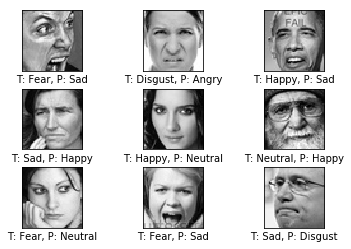

Confusion Matrix:


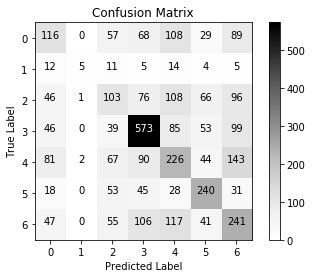

In [67]:
test(show_example_errors=True,
     show_confusion_matrix=True)

In [68]:
# Close session
session.close()